In [75]:
import kmodels as kmk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# get torch pretty mokey patch
import lovely_tensors as lt
import plotly.express as px
lt.monkey_patch()

In [76]:
def to_torch(X):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X.astype(np.float32))
    elif isinstance(X, pd.DataFrame):
        X = X.values
        X = torch.from_numpy(X.astype(np.float32))
    return X
def to_plot_var(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    return x
# for each subject make a large array of copipes of the x data where each muscle is deleted systematically and then the data is appeneded together
# this will be the input data


In [77]:

def get_cols_names():
    x_cols = ['FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB', 'Fx', 'Fy', 'Fz']
    y_cols = ['Pain_Cohort', 'Eaton_Litter']
    return x_cols, y_cols

def get_muscle_names():
    return ['FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB']

# write a function that will take in a dataframe and return a list of muscles that are active (that have non-zero values)
def get_active_muscles(train_df):
    muscles = get_muscle_names()
    active_muscles = []
    for muscle in muscles:
        if train_df[muscle].sum() != 0:
            active_muscles.append(muscle)
    return active_muscles

# write a function that will take in a dataframe and return a list of muscles that are inactive (that have zero values)
def get_inactive_muscles(train_df):
    muscles = get_muscle_names()
    inactive_muscles = []
    for muscle in muscles:
        if train_df[muscle].sum() == 0:
            inactive_muscles.append(muscle)
    return inactive_muscles

# write a function that will take in the entire dataset and split it up by subject and event
def split_by_subject(train_df):
    grouped_df = train_df.groupby(['Subject','Event'])
    # return a list of dataframes for each subject and event
    return [grouped_df.get_group(x) for x in grouped_df.groups]

# lets write an augmentation function that will take in a dataframe and augment it by zeroing out one muscle at a time
def dataframe_to_augmented_dfs(train_df):
    # get the active and inactive muscles
    active_muscles = get_active_muscles(train_df)
    inactive_muscles = get_inactive_muscles(train_df)
    # make a copy of the dataframe
    dfs = []
    df_copy = train_df.copy()
    # for each active muscle, make a copy of the dataframe and zero out that muscle
    for muscle in active_muscles:
        df_copy[muscle] = 0
        dfs.append(df_copy.copy())
        df_copy = train_df.copy()
    # return the augmented dataframe
    return dfs
    

# lets write a function that takes the original dataframe and outputs the augmented dataframe
def augment_df(train_df):
    # split the dataframe by subject and event
    dfs = split_by_subject(train_df)
    # for each dataframe, augment it and append it to a list
    augmented_dfs = []
    for train_df in dfs:
        augmented_dfs.extend(dataframe_to_augmented_dfs(train_df))
    # return the list of augmented dataframes
    return augmented_dfs

# lets write a function that will take in a list of dataframes and return a list of the x and y data
def get_x_y_data(train_df):
    x_cols, y_cols = get_cols_names()
    x_data = []
    y_data = []
    x_og = []
    dfs = augment_df(train_df)
    for loop_df in dfs:
        loop_df = loop_df.sort_values(by=['Event','Frame'])
        x_data.append(loop_df[x_cols].values)
        y_data.append(loop_df[y_cols].values)
    return np.row_stack(x_data), np.row_stack(y_data)

# get the data of the un-augmented dataframe
def get_data(train_df):
    x_cols, y_cols = get_cols_names()
    groups = train_df.groupby(['Subject', 'Event'])
    X = []
    Y = []
    for name, group in groups:
        group = group.sort_values(by=['Event','Frame'])
        X.append(group[x_cols].values.reshape(1, -1))
        Y.append(group[y_cols].values[0,:])
    X = np.row_stack(X)
    Y = np.row_stack(Y)
    return X, Y

# create a function that will create x_og, which is the original x data with the missing data but corressponding to the un-augmented data. For each muscle the augmentor
# will make a copy of the dataframe and zero out that muscle. Take this into account to copy the data the appropriate number of times
def get_x_og(train_df):
    x_cols, y_cols = get_cols_names()
    muscles = get_muscle_names()
    groups = train_df.groupby(['Subject', 'Event'])
    X = []
    Y = []
    for name, group in groups:
        used_muscles = get_active_muscles(group)
        for muscle in used_muscles:
            group = group.sort_values(by=['Event','Frame'])
            X.append(group[x_cols].values.reshape(1, -1))
            Y.append(group[y_cols].values)
    X = np.row_stack(X)
    Y = np.row_stack(Y)
    return X, Y

def get_number_of_frames(train_df):
    # find how many frames each event ran to
    # (find the unique values of "frames")
    frames = train_df['Frame'].unique()
    return len(frames)


In [78]:
df = pd.read_pickle('./data/ML_Data.pkl')
by_event = True # this makes it so you can switch back and forth between the format we talk about. 3 events per observation or 1 event per observation
nframes = get_number_of_frames(df)
n_events = 3
n_muscles = 11

In [79]:
subject_dfs =  split_by_subject(df)
# find which subjects have at least n working muscles
n = 6
working_subjects = []
for subject_df in subject_dfs:
    if len(get_active_muscles(subject_df)) >= n:
        working_subjects.append(subject_df['Subject'].values[0])
leave_out_df = df[~df['Subject'].isin(working_subjects)]
train_df = df[df['Subject'].isin(working_subjects)]
train_df['Subject'].unique(), leave_out_df['Subject'].unique()

(array(['EH61', 'FA66', 'KK56', 'UP48', 'EK32', 'LN24', 'OP55', 'KE58',
        'TO66', 'JX58', 'BX24', 'EO97'], dtype=object),
 array(['AO31', 'TS54', 'ZZ72', 'YF74', 'DZ62', 'BX36', 'OU92', 'NA46'],
       dtype=object))

In [80]:
print('TRAINING SET')
# lets make a pretty table of how many subjects have pain and how many don't
pain_df = train_df[train_df['Pain_Cohort'] == 1]
no_pain_df = train_df[train_df['Pain_Cohort'] == 0]
print('Number of subjects with pain: {}'.format(len(pain_df['Subject'].unique())))
print('Number of subjects without pain: {}'.format(len(no_pain_df['Subject'].unique())))
print()
print('LEAVE OUT SET')
# do the same for the leaveout set
pain_df = leave_out_df[leave_out_df['Pain_Cohort'] == 1]
no_pain_df = leave_out_df[leave_out_df['Pain_Cohort'] == 0]
print('Number of subjects with pain: {}'.format(len(pain_df['Subject'].unique())))
print('Number of subjects without pain: {}'.format(len(no_pain_df['Subject'].unique())))


TRAINING SET
Number of subjects with pain: 4
Number of subjects without pain: 8

LEAVE OUT SET
Number of subjects with pain: 4
Number of subjects without pain: 4


In [81]:
# format data as trajectories
x, y = get_x_y_data(train_df)
y = y.reshape(-1, nframes, 2)
x_og, y_og = get_x_og(train_df)
x = x.reshape(-1, nframes, 11)
x_og = x_og.reshape(-1, nframes, 11)
y_og = y_og.reshape(-1, nframes, 2)
# get the leaveout data and format as trajectories
leaveout_x, leaveout_y = get_x_y_data(leave_out_df)
leaveout_x = leaveout_x.reshape(-1, nframes, n_muscles)
leaveout_y = leaveout_y.reshape(-1, nframes, 2)

x.shape, y.shape, x_og.shape, y_og.shape, leaveout_x.shape, leaveout_y.shape

((234, 1000, 11),
 (234, 1000, 2),
 (234, 1000, 11),
 (234, 1000, 2),
 (96, 1000, 11),
 (96, 1000, 2))

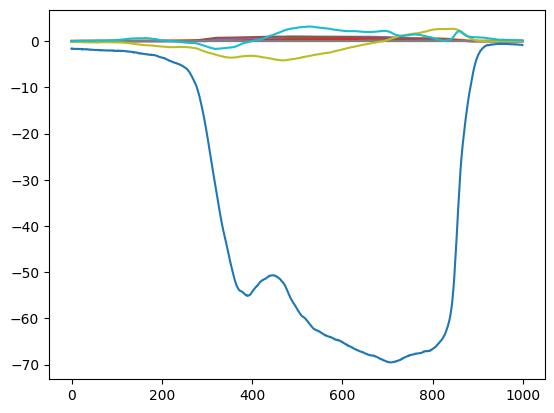

In [82]:
# for each trajectory, take the last 3 columns of x data and find the magnitude of the force vector
# x_force = np.linalg.norm(x[:, :, 8:11], axis=0)
# x_og_force = np.linalg.norm(x_og[:, :, 8:11], axis=0)
# leaveout_x_force = np.linalg.norm(leaveout_x[:, :, 8:11], axis=0)

for i in range(11):
    plt.plot(x[0, :, i])
# plot force as dots
# plt.plot(x[0, :, 8:11], '*')
# # now normalize each trajectory by the max force of that trajectory
# x_force = x_force / np.max(x_force, axis=1, keepdims=True)
# x_og_force = x_og_force / np.max(x_og_force, axis=1, keepdims=True)
# leaveout_x_force = leaveout_x_force / np.max(leaveout_x_force, axis=1, keepdims=True)
# print(x_force.shape, x_og_force.shape, leaveout_x_force.shape)
# # replace the data in the last 3 columns of x with the normalized force data
# x[:, :, 8:11] = x_force
# x_og[:, :, 8:11] = x_og_force
# leaveout_x[:, :, 8:11] = leaveout_x_force
# sample = 12
# # the first x data. each feature will be a line
# for i in range(11):
#     plt.plot(x[sample, :, i])
# # plot the force data as a dotted line
# plt.plot(x[sample, :, 8:11], 'k--')

In [83]:
# lets get the datafrom the original dataframe
x_cols = ['Fx', 'Fy', 'Fz', 'FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP','FPB']
y_cols = ['Pain_Cohort', 'Eaton_Litter']
x_data = train_df[x_cols].values
y_data = train_df[y_cols].values
x_data = x_data.reshape(-1, nframes, n_muscles)
y_data = y_data.reshape(-1, nframes, len(y_cols))

x_data.shape, y_data.shape, leaveout_y.shape

((36, 1000, 11), (36, 1000, 2), (96, 1000, 2))

In [84]:
# get the data from the leaveout train_df
if by_event:
    leaveout_x = leaveout_x.reshape(-1, nframes*n_muscles)
    # get the value for leaveout_y. Only grab the first value of each evnet
    leaveout_y = leaveout_y[:, 0, :]
    y_data = y_data[:, 0, :]
    y = y[:, 0, :]
    y_og = y_og[:, 0, :]
else:
    leaveout_x = leaveout_x.reshape(-1,  nframes*n_muscles*n_events)
    y_data = y_data.reshape(-1, nframes*n_events, 2)
    leaveout_y = leaveout_y.reshape(-1, nframes*n_events, 2)
    y = y.reshape(-1, nframes*n_events, 2)
    y_og = y_og.reshape(-1, nframes*n_events, 2)
    leaveout_y = leaveout_y[:, 0, :]
    y_data = y_data[:, 0, :]
    y = y[:, 0, :]
    y_og = y_og[:, 0, :]
leaveout_y = to_torch(leaveout_y).float()
leaveout_x.shape, leaveout_y.shape, y_data.shape, y.shape, y_og.shape

((96, 11000), torch.Size([96, 2]), (36, 2), (234, 2), (234, 2))

In [85]:
# convert the x dimensions depending if we want to group by trajectories or 3 trajectories
if by_event:
    x = x.reshape(-1, nframes*11)
    x_data = x_data.reshape(-1, nframes*11)
    x_og = x_og.reshape(-1, nframes*11)
else:
    x = x.reshape(-1, nframes*11*3)
    x_data = x_data.reshape(-1, nframes*11*3)
    x_og = x_og.reshape(-1, nframes*11*3)

x.shape

(234, 11000)

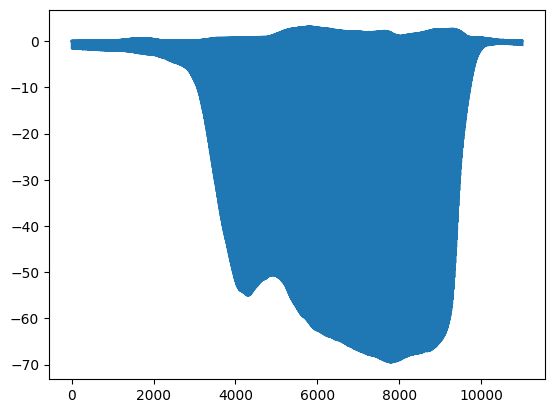

In [86]:
plt.plot(x[0,:])

In [87]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x_data = scaler.transform(x_data)
x_og = scaler.transform(x_og)
leaveout_x = scaler.transform(leaveout_x)
x.shape, x_data.shape, x_og.shape, leaveout_x.shape

((234, 11000), (36, 11000), (234, 11000), (96, 11000))

(array([75.,  0.,  0., 78.,  0.,  0., 60.,  0.,  0., 21.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

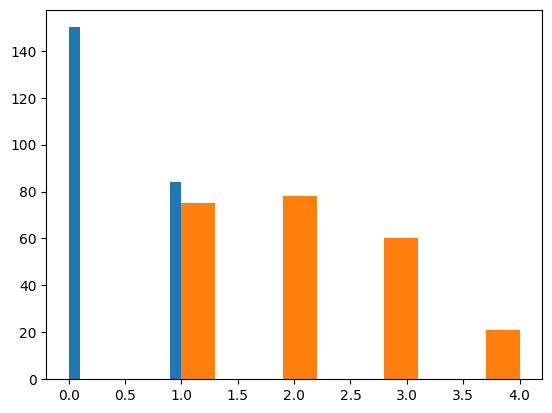

In [88]:
plt.hist(y[:,0])
plt.hist(y[:,1])

In [89]:
# plot the latent space of the un-augmented data
X_prime, Y_prime = get_data(train_df)
if by_event:
    X_prime = X_prime.reshape(-1, nframes*n_muscles)
    
else:
    X_prime = X_prime.reshape(-1, nframes*n_muscles*n_events)
    Y_prime = Y_prime[::n_events,:]
X_prime = scaler.transform(X_prime)
X_prime.shape, Y_prime.shape

((36, 11000), (36, 2))

In [90]:
X = to_torch(x)
X_og = to_torch(x_og)
Y = to_torch(y)
X_prime = to_torch(X_prime)
Y_prime = to_torch(Y_prime)

X = torch.cat((X, X_prime), dim=0)
Y = torch.cat((Y, Y_prime), dim=0)
Y_og = torch.cat((Y, Y_prime), dim=0)
X_og = torch.cat((X_og, X_prime), dim=0)
leaveout_x = to_torch(leaveout_x).float().reshape(-1, nframes, 11)
leaveout_y = to_torch(leaveout_y).float().reshape(-1, nframes, 2)
X.shape, Y.shape, X_og.shape, Y_prime.shape

RuntimeError: shape '[-1, 1000, 2]' is invalid for input of size 192

(array([150.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  84.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

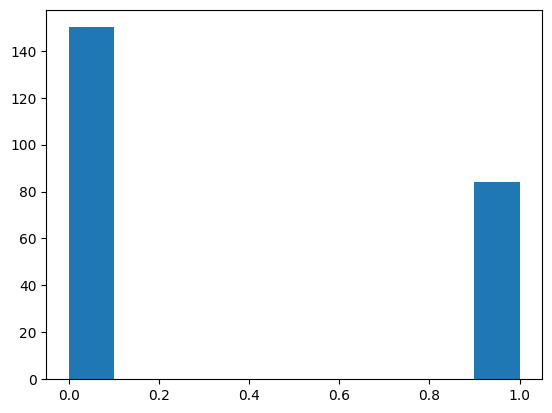

In [74]:
plt.hist(y[:,0])

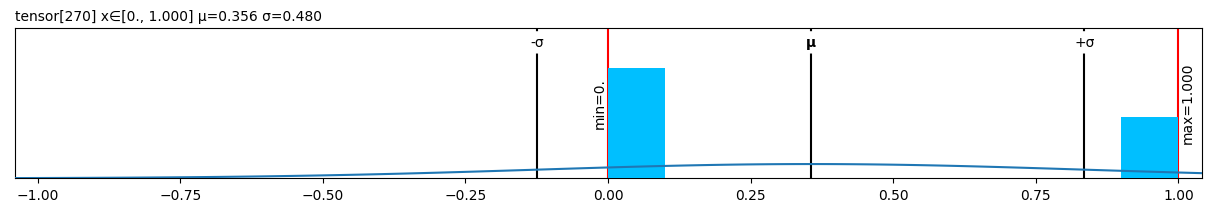

In [17]:
Y[:,0].plt

In [18]:
config = {
    'estimator_type': 'VAE',
    'n_inputs': X.shape[1],
    'n_outputs': X.shape[1],
    'input_dim': X.shape[1],
    'is_VAE': True,
    'batch_size':512, 
    'epochs':10001, 
    'verbose':10,
    'latent_dim': 2,
    'lr_init':1e-3,
    'reg_factor':0,
    'n_layers':3,
    'hidden_dim':int(X.shape[1]/100),
    'beta':1,
    'gamma':1,
    'device':'cuda', # makes it run on GPU
}

In [19]:
reg = kmk.Trainer(**config)
reg.estimator


VAE(
  (fc1): Linear(in_features=11000, out_features=110, bias=True)
  (encoder_layers): ModuleList(
    (0): Linear(in_features=110, out_features=110, bias=True)
    (1): Linear(in_features=110, out_features=110, bias=True)
    (2): Linear(in_features=110, out_features=110, bias=True)
  )
  (out1): Linear(in_features=110, out_features=2, bias=True)
  (out2): Linear(in_features=110, out_features=2, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=11000, out_features=110, bias=True)
    (1): ModuleList(
      (0): Linear(in_features=110, out_features=110, bias=True)
      (1): Linear(in_features=110, out_features=110, bias=True)
      (2): Linear(in_features=110, out_features=110, bias=True)
    )
    (2): Linear(in_features=110, out_features=2, bias=True)
    (3): Linear(in_features=110, out_features=2, bias=True)
  )
  (fc3): Linear(in_features=2, out_features=110, bias=True)
  (decoder_layers): ModuleList(
    (0): Linear(in_features=110, out_features=110, bias=True)
 

In [20]:
reg.fit(X, X_og)

====> Epoch: 0 Average loss: 867540.125000000 Time: 2.41
Loss components: {'VAE_loss': tensor cuda:0 8.670e+05, 'L1_regularization': tensor grad MulBackward0 cuda:0 528.414, 'L2_regularization': tensor grad MulBackward0 cuda:0 16.904}
====> Epoch: 10 Average loss: 511620.218750000 Time: 0.16
Loss components: {'VAE_loss': tensor cuda:0 5.111e+05, 'L1_regularization': tensor grad MulBackward0 cuda:0 528.918, 'L2_regularization': tensor grad MulBackward0 cuda:0 17.085}
====> Epoch: 20 Average loss: 273034.312500000 Time: 0.16
Loss components: {'VAE_loss': tensor cuda:0 2.725e+05, 'L1_regularization': tensor grad MulBackward0 cuda:0 529.515, 'L2_regularization': tensor grad MulBackward0 cuda:0 17.348}
====> Epoch: 30 Average loss: 246980.171875000 Time: 0.18
Loss components: {'VAE_loss': tensor cuda:0 2.464e+05, 'L1_regularization': tensor grad MulBackward0 cuda:0 529.741, 'L2_regularization': tensor grad MulBackward0 cuda:0 17.502}
====> Epoch: 40 Average loss: 238757.796875000 Time: 0.20

KeyboardInterrupt: 

In [ ]:
# send everything to the cpu

X = to_plot_var(X)
X_og = to_plot_var(X_og)
Y = to_plot_var(Y)
X_prime = to_plot_var(X_prime)
Y_prime = to_plot_var(Y_prime)
X_og = to_plot_var(X_og)
y_og = to_plot_var(y_og)
reg.estimator = reg.estimator.cpu()
if isinstance(reg.estimator, torch.nn.Module):
    reg.estimator = reg.estimator.to('cpu')
    reg.device = 'cpu'
if isinstance(reg.losses, torch.Tensor):
    reg.losses = reg.losses.cpu().detach().numpy()
X, reg.estimator, Y

(array([[0.        , 0.9340449 , 0.00189249, ..., 0.45875505, 0.6048229 ,
         0.04198594],
        [0.00761428, 0.9340449 , 0.00189249, ..., 0.45875505, 0.6048229 ,
         0.04198594],
        [0.        , 1.        , 0.00134056, ..., 0.8152212 , 0.3928911 ,
         0.07034631],
        ...,
        [0.09999542, 0.37824193, 0.03807078, ..., 0.9227456 , 0.47831643,
         0.29586828],
        [0.        , 0.77745676, 0.2553293 , ..., 0.54029834, 0.352356  ,
         0.57750875],
        [0.01796399, 0.        , 0.18320225, ..., 0.6045249 , 0.4532244 ,
         0.2044399 ]], dtype=float32),
 VAE(
   (fc1): Linear(in_features=33000, out_features=330, bias=True)
   (encoder_layers): ModuleList(
     (0): Linear(in_features=330, out_features=330, bias=True)
     (1): Linear(in_features=330, out_features=330, bias=True)
     (2): Linear(in_features=330, out_features=330, bias=True)
   )
   (out1): Linear(in_features=330, out_features=2, bias=True)
   (out2): Linear(in_features=330,

In [ ]:
px.line(np.log(reg.losses), title='Loss')

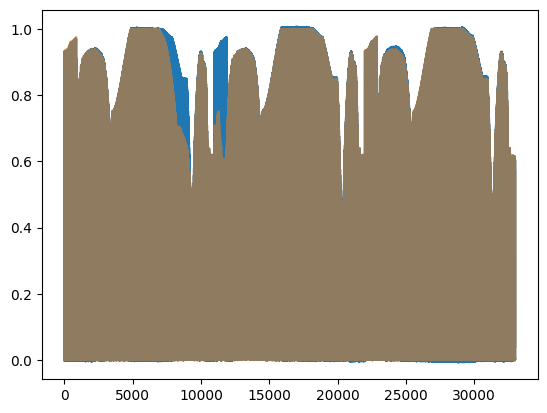

In [ ]:
# plot the recon error
X_hat = reg.predict(X)
X_hat = to_plot_var(X_hat)
plt.plot(X_hat[0])
plt.plot(X[0],alpha=0.5)


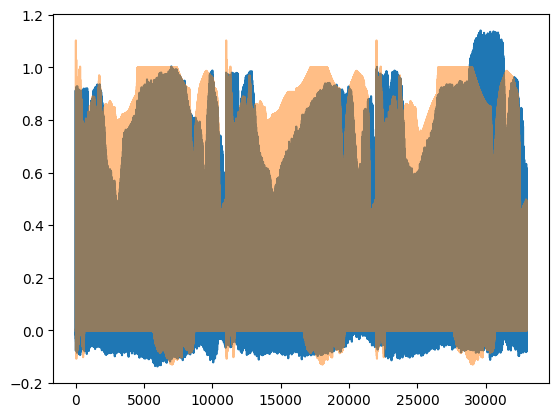

In [ ]:
# plot the recon error for leaveout data
pred_leaveout = reg.predict(leaveout_x)
pred_leaveout = to_plot_var(pred_leaveout)
plt.plot(pred_leaveout[0])
plt.plot(leaveout_x[0], alpha=0.5)

In [ ]:
# get the r2 of the leaveout set
r2_score(leaveout_x, pred_leaveout)

-8.622450529927914

In [ ]:
# pass the data through the model
X_prime_hat = to_plot_var(reg.predict(X_prime))
X_prime_hat.shape, X_prime.shape, Y.shape, X.shape

((12, 33000), (12, 33000), (90, 2), (90, 33000))

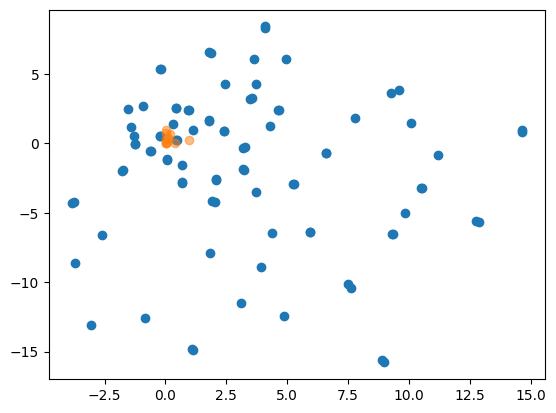

In [ ]:
# get the encoded latent space and plot
X_encoded = to_plot_var(reg.estimator.encode(to_torch(X))[0])
plt.scatter(X_encoded[:,0], X_encoded[:,1])
# plot X_prime_hat as red dots
plt.scatter(X_prime_hat[:,0], X_prime_hat[:,1], marker='o', alpha=0.5)

In [ ]:
import plotly.express as px
# cmap is red to blue
# encoded_df 
Edf = pd.DataFrame(X_encoded[:, 0:2], columns=['x1', 'x2'])
Edf['Pain_Cohort'] = Y[:,0]
Edf['Eaton_Litter'] = Y[:,1]
# make the pain cohort categorical
Edf['Pain_Cohort'] = Edf['Pain_Cohort'].astype('category')
# leaveout df
leaveout_x_encoded = to_plot_var(reg.estimator.encode(to_torch(leaveout_x))[0])
leaveout_df = pd.DataFrame(leaveout_x_encoded[:, 0:2], columns=['x1', 'x2'])
leaveout_y = pd.DataFrame(leaveout_y, columns=['Pain_Cohort', 'Eaton_Litter'])
leaveout_df = pd.concat([leaveout_df, leaveout_y], axis=1)
# make the pain cohort categorical
leaveout_df['Pain_Cohort'] = leaveout_df['Pain_Cohort'].astype('category')

# now make the pain 1 category * and 0 category o
#Edf['Pain_Cohort'] = Edf['Pain_Cohort'].apply(lambda x: '*' if x == 1 else 'o')
fig = px.scatter(Edf, x='x1', y='x2', color='Eaton_Litter', symbol='Pain_Cohort', hover_data=['Eaton_Litter'])
# make the size of the pain cohort bigger
# fig.update_traces(marker=dict(size=12,
#                                 line=dict(width=2,
#                                             color='DarkSlateGrey')),
#                     selector=dict(mode='markers', symbol='*')) 
# # make the markers bigger with nicer backgrounds
fig.update_traces(marker=dict(size=12,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
# we want to really emphasize the Pain Cohort == 1 group. lets make the marker size much larger
fig.update_traces(marker=dict(size=209,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers', symbol='o'))
# make the figure larger and have a square aspect ratio
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor="LightSteelBlue",
)
# # add the X_prime_hat as red dots
# # color the using Y_prime
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# fig.add_trace(
#     go.Scatter(
#         x=X_prime_hat[:,0],
#         y=X_prime_hat[:,1],
#         mode="markers",
#         marker=dict(
#             color=Y_prime[:,0],
#             size=12,
#             line=dict(
#                 color='Red',
#                 width=2
#             )
#         ),
#         name="X_prime_hat"
#     )
# )
# add leaveout data
# make the pain cohort categorical, 1 is * and 0 is o
# use px.scatter just like before, but put the plots together
leaveout_fig = px.scatter(leaveout_df, x='x1', y='x2', color='Eaton_Litter', symbol='Pain_Cohort', hover_data=['Eaton_Litter'])
# make the leaveout_fig makers have a red outline
leaveout_fig.update_traces(marker=dict(size=12,
                                line=dict(width=2,
                                            color='Red')),
                    selector=dict(mode='markers'))

# get the markers from leaveout_fig and put them in fig
for trace in leaveout_fig.data:
    fig.add_trace(trace)
fig.show()
# save as latent space.html
fig.write_html("latent_space.html")

In [ ]:
# save the entire reg. use dill
import dill
with open('reg3.dill', 'wb') as f:
    dill.dump(reg, f)
    

In [ ]:
reg.estimator
# get the number of learnable parameters
sum(p.numel() for p in reg.estimator.parameters() if p.requires_grad)

22471024

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
r2 = r2_score(X_prime, X_prime_hat)
mse = mean_squared_error(X_prime, X_prime_hat)
mae = mean_absolute_error(X_prime, X_prime_hat)
print(f'r2: {r2}, mse: {mse}, mae: {mae}')

r2: 0.9980530483030869, mse: 8.486869046464562e-05, mae: 0.006547745317220688


In [ ]:
# plot the predictions of X_prime
pred  = reg.predict(X_prime)
pred = pred.detach().cpu().numpy()

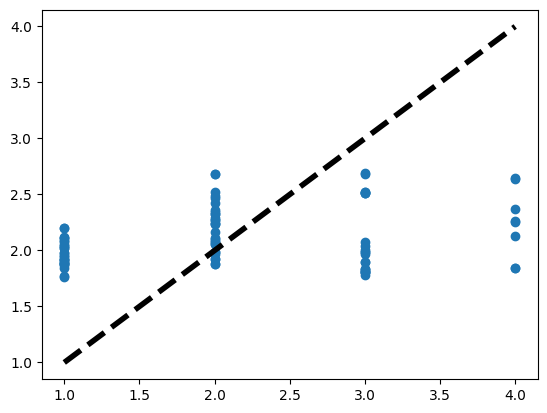

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_encoded, Y[:,1])
lin_reg.score(X_encoded, Y[:,1])
# plot the parity
plt.scatter(Y[:,1], lin_reg.predict(X_encoded))
# parity line
plt.plot([Y[:,1].min(), Y[:,1].max()], [Y[:,1].min(), Y[:,1].max()], 'k--', lw=4)


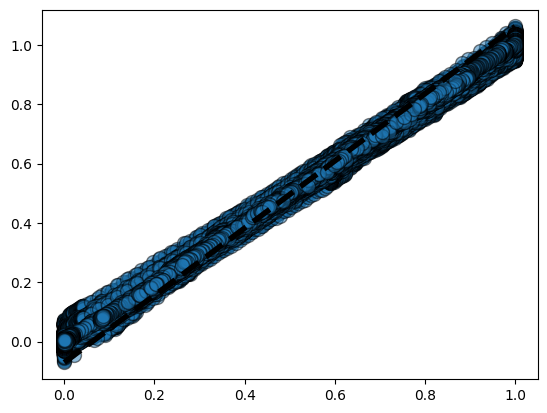

In [ ]:
# plot the parity of the predictions
pred = reg.predict(X).detach().cpu().numpy()
plt.scatter(X_og.reshape(-1), pred.reshape(-1), alpha=0.5, edgecolors='k', s=100)
# parity line
plt.plot([X_og.min(), X_og.max()], [pred.min(), pred.max()], 'k--', lw=4)

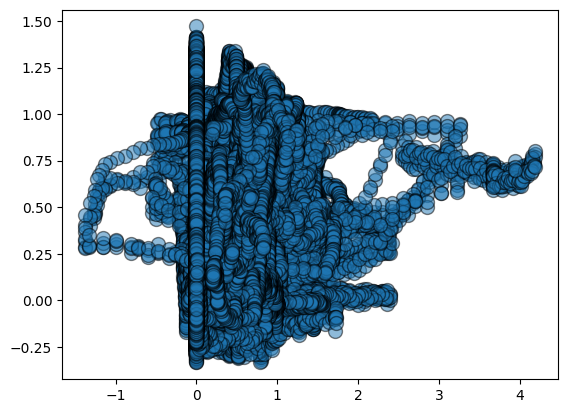

In [ ]:
# predict on all the leaveout data
pred_leaveout = reg.predict(leaveout_x).detach().cpu().numpy()
leaveout_x_encoded  = reg.estimator.encode(to_torch(leaveout_x))[0].detach().cpu().numpy()
# parity of pred_levaeout
plt.scatter(leaveout_x.reshape(-1), pred_leaveout.reshape(-1), edgecolors='k', s=100, alpha=0.5)

## clustering

In [ ]:
# get a logistic re